## Analysis of TE data (SLiM) from Stitzer _et al_ 2021
#### Dec, 2022

In [3]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
import sys
sys.path.append('../')
from mom_functions import *

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
## reading in the data
# os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
# snpdat = np.genfromtxt("outfiles/SNP_generation_5000_neg_sel_s_0.005_bottleneck_run_number_1.out.txt",delimiter=',',skip_header=1,skip_footer=1)

# plt.scatter(snpdat[:,1]+1,snpdat[:,2]*1000,alpha=0.5); plt.loglog();
# plt.hist(snpdat[:,2]*1000,25)
# fs = moments.Spectrum(np.histogram(snpdat[:,2]*1000,bins=range(0,1002))[0])
# for g in np.linspace(0,1,10):
#     print(g)
#     print(get_ll_freqconstantTE(g,{'sfs':fs,'theta':5e4,'p_misid':0},1000))

### Joint estimation of mutation rate $\theta$ & selection coefficient $\gamma$ from a constant population size

In [119]:
## simulate the data, simple: single gamma, single theta 
fsa = run_mom_iterate_constant(10000, 200, -10/10000, 10000, 100, {})
fsa[fsa<0] = -fsa[fsa<0]

mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
SMS = np.zeros_like(fsa)
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)

In [126]:
# -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':500,'N':10000,'p_misid':0,'gens':10000},200)).x
# get_ll_thetaconstant(np.log10([10,500]),{'sms':SMSmask,'N':10000,'gens':10000},200)
nsims = 15
# estpar = np.zeros((nsims,2))
estparf = np.zeros((nsims,2))
for n in range(nsims):
    SMS = np.zeros_like(fsa)
    for i in range(1,SMS.shape[0]):
        for j in range(1,SMS.shape[1]):
            SMS[i,j] = rng.poisson(fsa[-i,j],1)
    SMSmask = np.ma.array(SMS,mask=mask)

    sfs = SMSmask.sum(axis=0)

    # tempres = sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))
    tempres = sp.optimize.minimize(get_ll_thetaconstant_freq,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sfs':sfs},200),bounds=((-3,3),(0,4)))
    estparf[n,0] = -10**tempres.x[0]
    estparf[n,1] = 10**tempres.x[1]
    print(estparf[n,])
# sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,100]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))

[-10.893 101.434]
[-8.212 90.112]
[-9.503 99.695]
[-11.020 93.417]
[-10.495 97.015]
[-9.498 88.465]
[-9.510 98.521]
[-10.593 109.491]
[-9.134 93.052]
[-10.372 96.145]
[-11.739 107.612]
[-12.702 111.627]
[-10.427 97.587]
[-9.561 107.157]
[-11.957 107.983]


(-15.0, -5.0)

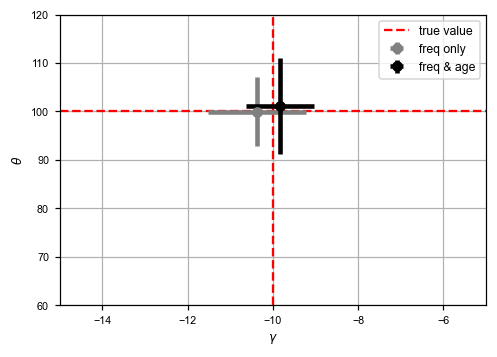

In [133]:
plt.axvline(-10,color='red',ls='--',label='true value'); plt.axhline(100,color='red',ls='--'); plt.grid(); plt.ylim((60,120))
plt.errorbar(np.mean(estparf[:,0]),np.mean(estparf[:,1]),xerr=np.std(estparf[:,0]),yerr=np.std(estparf[:,1]),fmt='o',color='grey',label='freq only',elinewidth=3); plt.errorbar(np.mean(estpar[:,0]),np.mean(estpar[:,1]),xerr=np.std(estpar[:,0]),yerr=np.std(estpar[:,1]),fmt='o',color='k',label='freq & age',elinewidth=3); 
plt.xlabel(r'$\gamma$'); plt.ylabel(r'$\theta$'); plt.legend(); plt.xlim((-15,-5))

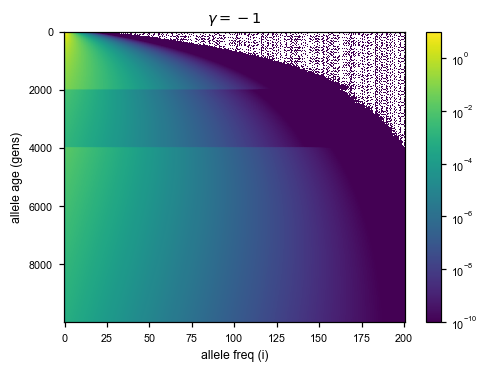

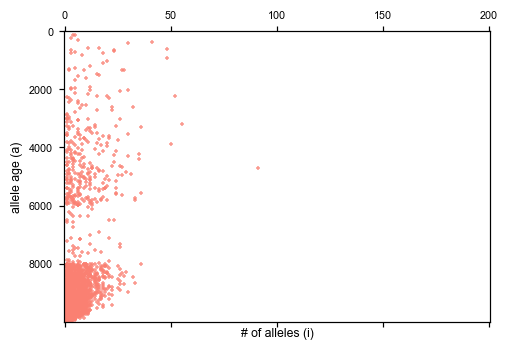

In [77]:
## simulate data for slightly more complex scenario: single gamma, bottleneck theta with **GIVEN** changepoints
# need a way to manipulate the run_mom_iterate internal values (using a specific theta model)
# plot what the expected fsa & SMSmask look like (do 10x increase)
theta = np.repeat(2000,10000); theta[2000:4000] = 200
fsa = run_mom_iterate_theta(10000, 200, -10/10000, 10000, theta, {})
plt.imshow(fsa[::-1], aspect='auto', norm=colors.LogNorm(vmin=1e-10)); plt.title(r'$\gamma = -1$'); plt.xlabel('allele freq (i)'); plt.ylabel('allele age (gens)'); plt.colorbar(); plt.show()
mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
SMS = np.zeros_like(fsa)
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask[::-1],aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

In [204]:
sp.optimize.minimize(get_ll_theta_bottleneck,x0=np.log10([10,5,20]),method='L-BFGS-B',args=({'sms':SMSmask,'N':10000,'gens':10000,'changept1':2000,'changept2':4000},200),bounds=((-3,3),(0,4),(0,4)))
# np.sqrt(np.diag(B.hess_inv.todense()))
get_ll_theta_bottleneck(np.log10([1,250,5000]),{'sms':SMSmask,'N':10000,'gens':10000,'changept1':200,'changept2':400})

      fun: 2438.4940795750167
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.870, 2.328, -2.583])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 92
      nit: 8
     njev: 23
   status: 0
  success: True
        x: array([-0.195, 2.041, 1.629])

In [ ]:
# def optim_func(x0):
#     return sp.optimize.minimize(get_ll_theta_bottleneck,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-1,3),(0,4),(0,4),(0,4),(1,4)))
# get_ll_theta_bottleneck(np.log10([10,2000,200,2000,2000]),{'sms':SMSmask,'N':10000,'gens':10000})
# x_init = np.vstack((np.random.uniform(0,2,6), np.random.uniform(2,4,6), np.random.uniform(1,3,6), np.random.uniform(2,4,6), np.random.uniform(1,4,6)))
# finalres = Parallel(n_jobs=2)(delayed(optim_func)(x) for x in x_init[:,:2].T)
# sp.optimize.minimize(get_ll_theta_bottleneck,x0=[1,3,2,3,3],method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-1,3),(0,4),(0,4),(0,4),(1,4)))
# estpar = np.zeros((nsims,4))
# for n in range(nsims):
#     SMS = np.zeros_like(fsa)
#     for i in range(1,SMS.shape[0]):
#         for j in range(1,SMS.shape[1]):
#             SMS[i,j] = rng.poisson(fsa[-i,j],1)
#     SMSmask = np.ma.array(SMS,mask=mask)

#     x_init = np.vstack((np.random.uniform(0,2,6), np.random.uniform(2,4,6), np.random.uniform(1,3,6), np.random.uniform(2,4,6)))
#     finalres = Parallel(n_jobs=6)(delayed(optim_func)(x) for x in x_init.T)
#     estpar[n,] = 10**finalres[np.argmin([i.fun for i in finalres])].x
#     print(estpar[n,])

In [272]:
## simulate data for slightly more complex scenario: single gamma, two epoch theta with unknown changepoint
theta = np.repeat(2000,10000); theta[4000:] = 1000
fsa = run_mom_iterate_theta(10000, 100, -10/10000, 10000, theta, {})
# plt.imshow(fsa, aspect='auto', norm=colors.LogNorm(vmin=1e-10)); plt.grid(); plt.title(r'$\gamma = -5$'); plt.xlabel('allele freq (i)'); plt.ylabel('allele age (gens)'); plt.colorbar(); plt.show()
SMS = np.zeros_like(fsa)
mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)
# sfs = SMSmask.sum(axis=0)
# plt.imshow(fsa[::-1],aspect='auto',interpolation='nearest',norm=colors.LogNorm(vmin=1e-10),); plt.colorbar()
# plt.spy(SMSmask,aspect='auto',color='k',marker='+',markersize=2,alpha=0.3, origin='lower'); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()
# plt.plot(theta,'grey'); plt.xlabel('gens ago (a)'); plt.ylabel(r'$\theta$'); 
# SMSmask.sum()

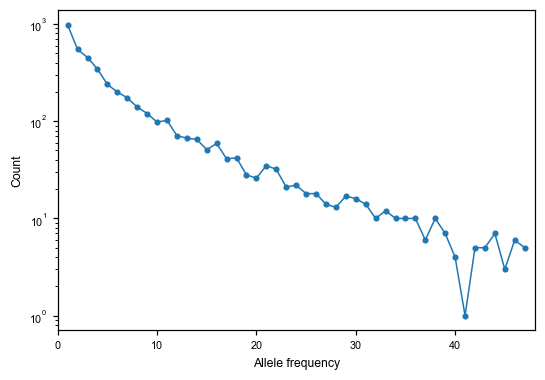

In [65]:
# plt.bar(x=np.arange(1,50),height=SMSmask.sum(axis=0)[1:50],color='pink',alpha=0.8,); plt.xlabel('# of alleles (i)'); plt.ylabel('count'); plt.title(r'SFS with $\gamma = -5$ & $\theta = 2000$'); plt.show()
# moments.Plotting.plot_1d_fs(moments.Spectrum(SMSmask.sum(axis=0)[1:50]))
# plt.plot(SMSmask.sum(axis=0)[:30],SMStwo.sum(axis=0)[:30],'ko'); plt.axline((0,0),slope=1,color='grey'); plt.xlabel(r'counts from constant $\theta$'); plt.ylabel(r'counts from varying $\theta$')

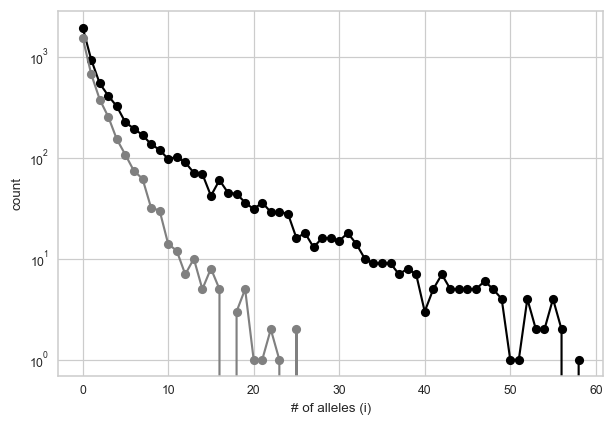

In [273]:
# plt.bar(x=np.arange(1,50),height=SMStwo.sum(axis=0)[1:50],color='pink',alpha=0.8,); plt.xlabel('# of alleles (i)'); plt.ylabel('count'); 
# moments.Plotting.plot_1d_fs(moments.Spectrum(SMStwo.sum(axis=0)[1:50]))
plt.style.use('seaborn-whitegrid')
plt.plot(SMStwo.sum(axis=0)[1:60],'k-o',markersize=6,label='');plt.semilogy(); plt.ylabel('count');plt.xlabel('# of alleles (i)')
plt.plot(SMSmask.sum(axis=0)[1:60],'-o',color='grey',markersize=6); plt.semilogy(); 
#plt.title(r'SFS with $\gamma=-10$ & varying $\theta$')

In [161]:
# tempres = sp.optimize.minimize(get_ll_theta_twoepoch,x0=np.log10([2,40,600,5000]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4),(0,4),(0,4)))
# get_ll_theta_twoepoch(np.log10([2,200,1000,400]),{'sms':SMSmask,'N':10000,'gens':10000})
# def optim_func(x0):
#     return sp.optimize.minimize(get_ll_theta_twoepoch,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},50),bounds=((-3,3),(0,4),(0,4),(0,4)))
def optim_func(x0):
    return sp.optimize.minimize(get_ll_theta_twoepoch_freq,x0=x0,method='Nelder-Mead',args=({'sfs':sfs,'sms':SMSmask,'N':10000,'gens':10000},100),bounds=((-3,3),(0,4),(0,4),(0,4)))
# estpar = np.zeros((nsims,4))
estparf = np.zeros((nsims,2)); estparf_likea = np.zeros((nsims,4))
for n in range(nsims):
    SMS = np.zeros_like(fsa)
    for i in range(1,SMS.shape[0]):
        for j in range(1,SMS.shape[1]):
            SMS[i,j] = rng.poisson(fsa[-i,j],1)
    SMSmask = np.ma.array(SMS,mask=mask)
    sfs = SMSmask.sum(axis=0)

    x_init = np.vstack((np.random.uniform(0,2,4), np.random.uniform(2,4,4), np.random.uniform(1,3,4), np.random.uniform(2,4,4)))
    finalres = Parallel(n_jobs=4)(delayed(optim_func)(x) for x in x_init.T)
#    estpar[n,] = 10**finalres[np.argmin([i.fun for i in finalres])].x
    estparf[n,] = 10**sp.optimize.minimize(get_ll_thetaconstant_freq,x0=[1,2],method='Nelder-Mead',args=({'sfs':sfs},100),bounds=((-3,3),(0,4))).x
    estparf_likea[n,] = 10**finalres[np.argmin([i.fun for i in finalres])].x
    print(estparf[n,], estparf_likea[n,])

ERROR! Session/line number was not unique in database. History logging moved to new session 311
[12.146 1998.635] [12.707 1940.955 2211.005 842.725]
[11.712 1946.895] [10.901 2250.004 1760.319 243.151]
[11.538 2019.030] [8.304 2031.122 338.230 2753.868]
[11.700 2008.701] [11.127 2030.318 1753.028 1724.987]
[12.510 2052.067] [10.296 2045.845 12.468 3579.410]
[11.641 2066.168] [9.824 2145.494 1349.023 1498.808]
[12.017 2046.809] [8.431 2108.445 625.637 1995.996]
[11.284 1981.301] [11.025 2339.507 1935.220 58.894]
[10.850 1942.070] [1.439 1935.571 12.855 2048.920]
[11.288 1963.614] [9.991 2052.205 1528.023 1135.222]
[11.004 1965.293] [4.132 1947.648 1.000 2430.314]
[11.675 2001.208] [123.937 5352.235 10.707 9216.836]
[11.890 2084.907] [11.726 7297.557 2060.950 2.000]
[11.538 1977.092] [0.079 1965.504 3.991 1816.001]
[10.920 1963.334] [11.112 1585.347 2032.116 77.012]


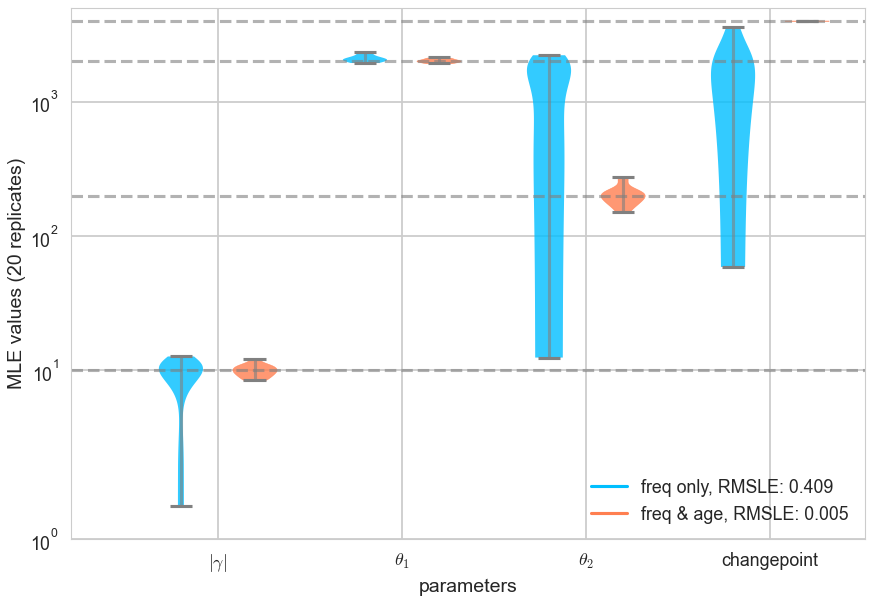

In [313]:
# estpar = np.array([[4.267, 1935.872, 176.742, 4007.919],[4.664, 1985.657, 214.660, 3998.000],[5.156, 2126.894, 183.250 ,4000.427],[5.473, 2072.574, 262.466 ,3997.041],[5.528, 2045.253, 198.868 ,4005.612],[5.053 ,2001.158 ,204.187 ,3999.672],[5.458, 2056.038 ,208.469, 3995.861],[6.108, 2118.825 ,273.831 ,3999.000],[4.936, 1988.867 ,219.945 ,3998.312],[4.363, 1930.973, 174.615, 4003.916],[4.787 ,2014.581, 172.977 ,3998.121],[5.086 ,1989.640, 199.238 ,3998.183],[5.358 ,2115.837, 201.220 ,3998.001],[4.360 ,1927.788 ,150.064 ,3987.875],[4.784, 2028.192, 213.389 ,4001.167]])
# estpar[:,0] = 2*estpar[:,0]

def setViolColors(bp):
    bp['bodies'][0].set_facecolor('deepskyblue')
    bp['bodies'][0].set_alpha(0.8)
    bp['bodies'][0].set_linewidth(1)
    bp['cbars'].set_colors('grey')
    bp['cbars'].set_alpha(0.6)
    bp['cmins'].set_color('grey')
    bp['cmaxes'].set_color('grey')
    # plt.setp(bp['cbars'][0], color='deepskyblue')
    # plt.setp(bp['caps'][1], color='deepskyblue')
    # plt.setp(bp['whiskers'][0], color='deepskyblue')
    # plt.setp(bp['whiskers'][1], color='deepskyblue')
    # plt.setp(bp['fliers'][0], color='deepskyblue')
    # plt.setp(bp['medians'][0], color='deepskyblue')

    plt.setp(bp['bodies'][1], color='coral', alpha=0.8)
    # plt.setp(bp['cbars'][1], color='coral')
    # plt.setp(bp['caps'][3], color='coral')
    # plt.setp(bp['whiskers'][2], color='coral')
    # plt.setp(bp['whiskers'][3], color='coral')
    # plt.setp(bp['fliers'][1], color='coral')
    # plt.setp(bp['medians'][1], color='coral')

fig = plt.figure(dpi=80)
# plt.style.use('bmh')
plt.style.use('seaborn-poster')
ax = plt.axes()
s = [10.,2000.,200.,4000.]
#-np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1]#np.array([1,10,100]) 

for i in range(len(s)):
    # bp = plt.boxplot([parestfreq[i,~np.isnan(parestfreq[i,:])],parestage[i,~np.isnan(parestage[i,:])]],positions=[3*i+1,3*i+2], widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5),)
    # setBoxColors(bp)
    vp = plt.violinplot([estparf_likea[:10,i],estpar[:,i]],positions=[2.5*i+1,2.5*i+2], widths=0.6,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6)

# bp = plt.boxplot([parestfreq0,parestage0],positions=[16,17],widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5))
# setBoxColors(bp) 
# vp = plt.violinplot([-parestfreq[-1,:],-parestage[-1,:]],positions=[9,10],widths=0.6,)
# setViolColors(vp)
# plt.axhline(0.,color='grey',ls='--',alpha=0.6);

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1.5,4,6.5,9]); ax.set_xticklabels([r'$|\gamma|$',r'$\theta_1$',r'$\theta_2$','changepoint']); 
ax.set_yscale('symlog'); #ax.set_yticks(s); 
ax.set_ylim((1,5000))

hB, = plt.plot(0,0,color='deepskyblue'); hR, = plt.plot(0,0,color='coral'); #hB.set_visible(True); hR.set_visible(True)
plt.xlabel('parameters'); plt.ylabel('MLE values (20 replicates)')
plt.legend((hB, hR),('freq only, RMSLE: {:.3f}'.format(np.sqrt(np.mean((np.log10(s)-np.log10(np.mean(estparf_likea.T,axis=1)))**2))), 'freq & age, RMSLE: {:.3f}'.format(np.sqrt(np.mean((np.log10(s)-np.log10(np.mean(estpar.T,axis=1)))**2)))),loc='lower right')
# plt.savefig("../figs/MLEfreqage2.pdf")

In [296]:
np.sqrt(np.mean((np.log10(s)-np.log10(np.mean(estpar.T,axis=1)))**2))

0.004701032471995673

In [73]:
## what if we think there is only one mutation rate? 
# finalres[2].fun, sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))
# Parallel(n_jobs=4)(delayed(optim_func)(x) for x in x_init.T), sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,10]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4)))

([<matplotlib.axis.XTick at 0x1459335e0>,
 [Text(1, 0, '$|\\gamma|$'),
  Text(2, 0, '$\\theta_1$'),
  Text(3, 0, '$\\theta_2$'),
  Text(4, 0, 'changepoint')])

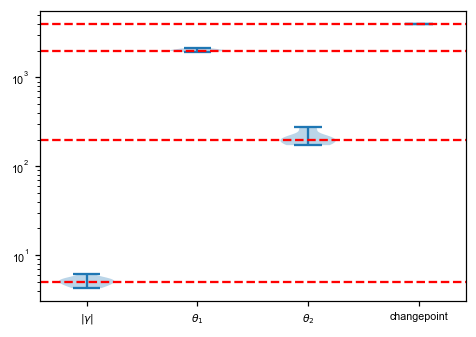

In [108]:
# estpar[10,] = [9.859, 2048.652, 195.156, 3989.037]
plt.violinplot(estpar[:11,]); plt.semilogy(); plt.axhline(5,color='red',ls='--'); plt.axhline(2000,color='red',ls='--'); plt.axhline(200,color='red',ls='--'); plt.axhline(4000,color='red',ls='--'); plt.xticks(range(1,5),labels=[r'$|\gamma|$',r'$\theta_1$',r'$\theta_2$','changepoint']) 
# plt.plot(range(51),SMSmask.sum(axis=0),'ko'); plt.loglog()
# np.percentile(estpar,[5,95],axis=0)
# sp.optimize.minimize(get_ll_theta_twoepoch,x0=[1.5,3.5,1.6,3],method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':10000},200),bounds=((-3,3),(0,4),(0,4),(0,4)))
# from joblib import Parallel, delayed
# finalres = Parallel(n_jobs=6)(delayed(my_func)(x) for x in x_init.T)
# 10**finalres[np.argmin([i.fun for i in finalres])].x

## Reading in TE data from Stitzer et al, 2021

The *te_ages_eightfams_nonascertained.txt* file contains 32 columns - 1:4 summarize the locus, 5 is the family identifier, 6:30 contain the age estimate for each allele, which sometimes I refer to as k2p age (the column names are variety names of different maize genotypes). The column has NA if that individual doesn't have a TE at that locus. Column 31 is the allele count from this sample of 26, and column 32 is the mean age across individuals with the allele. 

Looks like on average older alleles are higher in frequency, though there are a few very old alleles in the singleton and doubleton bins (potential genotyping errors)

Text(0.5, 1.0, 'Maize Chr1')

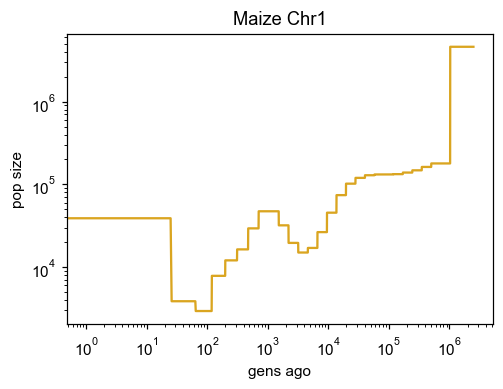

In [4]:
tedata = pd.read_csv("te_ages_eightfams_nonascertained.txt",sep='\t',header=0)

dem=pd.read_csv("nam.1.noouts.final.txt",delimiter='\t')

demogen = np.zeros(int(2.5e6))
for i in range(30):
    if i==29:
        endpt = len(demogen)
    else:
        endpt = dem['right_time_boundary'][i]/3.2e-8
    demogen[range(int(dem['left_time_boundary'][i]/3.2e-8),int(endpt))] = (1/dem['lambda'][i])/6.4e-8

plt.plot(demogen,'goldenrod'); plt.loglog(); plt.xlabel('gens ago'); plt.ylabel('pop size'); plt.title('Maize Chr1')

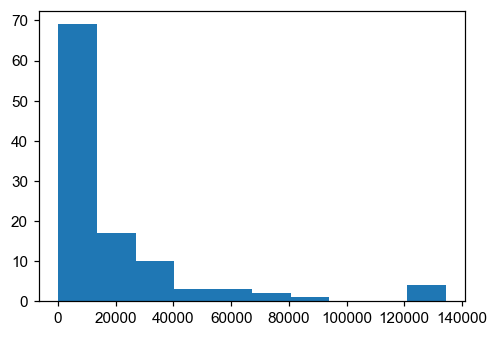

In [5]:
# ['RLC00002', 'RLC00004', 'RLC00030', 'RLC00032', 'RLG00001', 'RLG00003', 'RLG00008', 'RLG00011']
# [125, 178, 109, 127, 1214, 144, 118, 120]

plt.hist(tedata.iloc[np.where(tedata['fam']=='RLC00030')[0],-1]*1e6); #plt.hist(tedata.iloc[np.where(tedata['fam']=='RLC00002')[0],-1]/2/3.2e-8,15,color='grey',alpha=0.6)

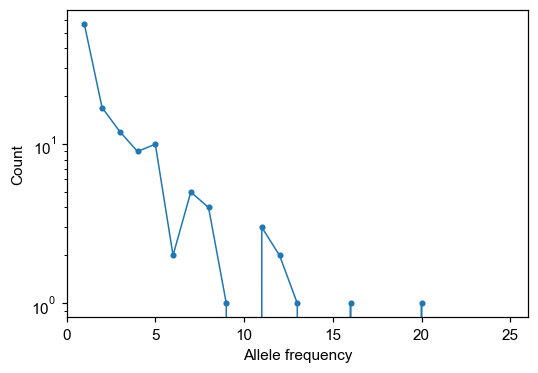

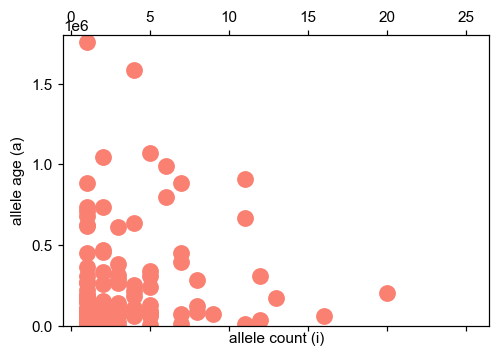

In [6]:
# plt.hist(tedata.loc[tedata['fam']=='RLC00032','allelecount'],bins=range(1,26),color='grey'); plt.xlabel('allele count'); plt.title('RLC00032')
# plt.hist(tedata.loc[tedata['fam']=='RLC00032','meanage']*1e6,15); plt.xlabel('mean k2p age (gens?)'); plt.title('RLC00032')

sfs = moments.Spectrum(np.histogram(tedata.loc[tedata['fam']=='RLC00002','allelecount'],bins=range(0,28))[0])
moments.Plotting.plot_1d_fs(sfs); plt.show()

mask = np.zeros((2500000,26+1),dtype='int16'); 
mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
SMS = np.zeros_like(mask) #sp.sparse.coo_array((1230850,26+1),dtype='int16')
for i in np.where(tedata['fam']=='RLC00002')[0]:
    if(tedata.iloc[i,-1]==0):
        SMS[1,tedata.iloc[i,-2]] += 1
    elif(tedata.iloc[i,-1]/2/3.2e-8<2500000):
    # else:
        SMS[int(tedata.iloc[i,-1]/2/3.2e-8),tedata.iloc[i,-2]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

plt.spy(SMSmask,aspect='auto',color='salmon',marker='o'); plt.ylim((-1000,1800000)); plt.xlabel('allele count (i)'); plt.ylabel('allele age (a)'); plt.show()

In [22]:
## MLE with freq alone gives gamma ~ -20 & theta ~ 200
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':500,'p_misid':0},26),bracket=(-2,3),options={'maxiter':20})
# get_ll_freqconstant(np.log10(15),{'sfs':sfs,'theta':200,'p_misid':0},26) 
# print(sp.optimize.minimize(get_ll_thetaconstant,x0=np.log10([10,100]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4))))
get_ll_thetaconstant(np.log10([10,100]),{'sms':SMSmask,'N':10000,'gens':1800000},26)
# print(sp.optimize.minimize(get_ll_thetaconstant_freq,x0=np.log10([10,100]),method='Nelder-Mead',args=({'sfs':sfs},26),bounds=((-3,3),(0,4))))
# get_ll_thetaconstant_freq(np.log10([10,100]),{'sfs':sfs,},26)
## ll = -1618 with gamma = -2.65 & theta = 63 for RLC00032 --> doesn't converge for more complex models
## ll = -1491 with gamma = -2.24 & theta = 80 for RLC00004
## ll = -1118 with gamma = -1.35 & theta = 45 for RLC00002
## ll = -1245 with gamma = -1.32 & theta = 38 for RLC00030
## ll = -1430 with gamma = -0.38 & theta = 40 for RLG00003
## ll = -1200 with gamma = -0.65 & theta = 37 for RLG00008

# sp.optimize.minimize(get_ll_theta_twoepoch,x0=np.log10([3,10,100,1000]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4),(0,4),(2,5)))
# get_ll_theta_twoepoch(np.log10([1.73,66,60,1500]),{'sms':SMSmask,'N':10000,'gens':80000},26)
# def optim_func_te(x0):
#     return sp.optimize.minimize(get_ll_theta_twoepoch,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4),(0,4),(2,4.9)))
# x_init_te = np.vstack((np.random.uniform(-2,2,6), np.random.uniform(0,4,6), np.random.uniform(0,4,6), np.random.uniform(2,5,6)))
# finalres_te = Parallel(n_jobs=6)(delayed(optim_func)(x) for x in x_init_te.T)
# print(finalres_te[np.argmin([i.fun for i in finalres_te])])
## ll = -1475 with gamma = -2.65 & theta1 = 7, theta2 = 106, changept = 780 for RLC00004 *
## ll = -1113 with gamma = -1.73 & theta1 = 26, theta2 = 60, changept = 1490 for RLC00002 
## ll = -1355 with gamma = -1.64 & theta1 = 11, theta2 = 168, changept = 10590 for RLG00003 *
## ll = -1180 with gamma = -0.83 & theta1 = 7.3, theta2 = 50, changept = 2100 for RLG00008 

# sp.optimize.minimize(get_ll_theta_bottleneck,x0=np.log10([2.18,130,40,112,15000]),method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4),(0,4),(2,4.8),(1.8,4.5)))
# def optim_func_bn(x0):
#     return sp.optimize.minimize(get_ll_theta_bottleneck,x0=x0,method='Nelder-Mead',args=({'sms':SMSmask,'N':10000,'gens':80000},26),bounds=((-3,3),(0,4),(0,4),(2,4.8),(1.8,4.2)))
# x_init_bn = np.vstack((np.random.uniform(-2,2,6), np.random.uniform(0,4,6), np.random.uniform(0,4,6), np.random.uniform(2,5,6), np.random.uniform(2,4,6)))
# finalres_bn = Parallel(n_jobs=6)(delayed(optim_func_bn)(x) for x in x_init_bn.T)
# print(finalres_bn[np.argmin([i.fun for i in finalres_bn])])
## ll = -1484 with gamma = -1.06 & theta1 = 68, theta2 = 1, changept = 100, dur = 678 for RLC00004
## ll = -1106 with gamma = -2.22 & theta1 = 138, theta2 = 40, changept = 100, dur = 15848 for RLC00002 *
## ll = -1372 with gamma = -1.46 & theta1 = 130, theta2 = 13, changept = 186, dur = 10000 for RLG00003 
## ll = -1170 with gamma = -1.95 & theta1 = 125, theta2 = 22, changept = 102, dur = 10000 for RLG00008 * 

8359.201

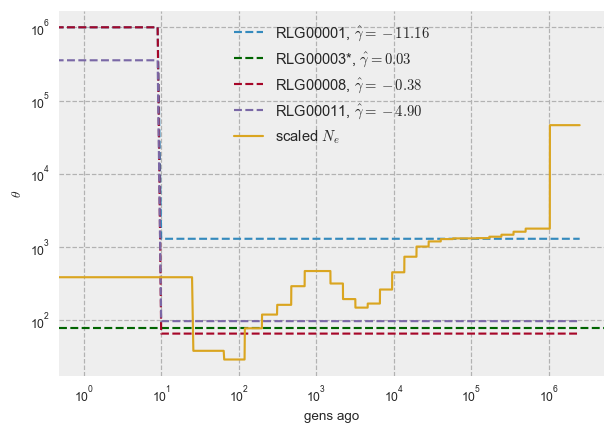

In [256]:
# def create_bottleneck_vec(theta1, theta2, changept, dur, tot):
#     mutrates = np.zeros(tot)
#     mutrates[:int(changept)] = theta1; mutrates[int(changept):int(changept+dur)] = theta2
#     mutrates[int(changept+dur):] = theta1
#     return mutrates

# def create_twoepoch_vec(theta1, theta2, changept, tot):
#     mutrates = np.zeros(tot)
#     mutrates[:int(changept)] = theta1
#     mutrates[int(changept):] = theta2
#     return mutrates

## output is 4\gamma/N[0] = s, therefore 2 x 4\gamma = 2N[0]s
plt.plot(create_twoepoch_vec(10**6, 10**3.114, 10**1, 2500000),ls='--',label=r'RLG00001, $\hat \gamma=-11.16$')
# plt.plot(create_twoepoch_vec(10**1.756, 10**1.935, 10**5.144, 2500000),ls='--',label=r'RLG00003, $\hat \gamma=0.06$')
plt.axhline(80,color='darkgreen',ls='--',label=r'RLG00003*, $\hat \gamma=0.03$')
plt.plot(create_twoepoch_vec(1e6, 10**1.82, 10**1, 2500000),ls='--',label=r'RLG00008, $\hat \gamma=-0.38$')
plt.plot(create_twoepoch_vec(10**5.55, 10**1.99, 10**1, 2500000),ls='--',label=r'RLG00011, $\hat \gamma=-4.90$')
plt.plot(demogen/100,'goldenrod',label=r'scaled $N_e$'); plt.xlabel('gens ago'); plt.ylabel(r'$\theta$'); plt.loglog(); plt.legend(loc='upper center',fontsize='large')
# plt.savefig('/Users/vivaswatshastry/selCoefEst/TEstuff/RLG14Feb23.jpeg',dpi=150)

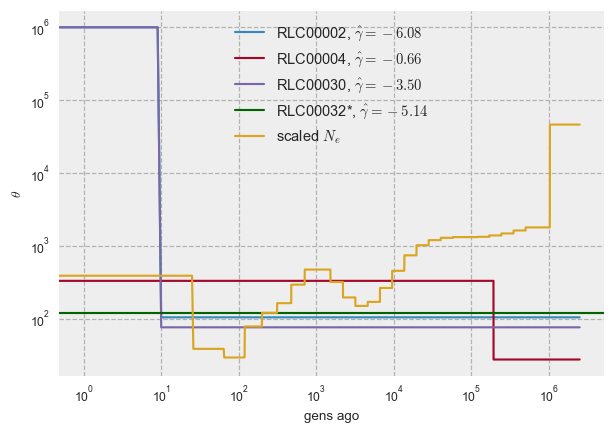

In [255]:
plt.plot(create_twoepoch_vec(1e6, 10**2.018, 10**1, 2500000),label=r'RLC00002, $\hat \gamma=-6.08$') 
plt.plot(create_twoepoch_vec(10**2.519, 10**1.439, 10**5.286, 2500000),label=r'RLC00004, $\hat \gamma=-0.66$')
plt.plot(create_twoepoch_vec(10**6, 10**1.881, 10**1, 2500000),label=r'RLC00030, $\hat \gamma=-3.50$')
# plt.plot(create_twoepoch_vec(10**6, 10**1.870, 10**1, 2500000),label=r'RLC00032, $\hat \gamma=-8.62$')
plt.axhline(118,color='darkgreen',label=r'RLC00032*, $\hat \gamma=-5.14$')
plt.plot(demogen/100,'goldenrod',label=r'scaled $N_e$'); plt.xlabel('gens ago'); plt.ylabel(r'$\theta$'); plt.loglog(); plt.legend(loc='upper center',fontsize='large')
plt.savefig('/Users/vivaswatshastry/selCoefEst/TEstuff/RLC14Feb23.jpeg',dpi=150)

In [245]:
## changing popsize incorporated here:
## plt.plot(demogen[:80000],'--',color='goldenrod',label='scaled Ne'); plt.semilogx()
# get_ll_thetaconstant_changing(np.log10([5,500]),{'sms':SMSmask,'Nc':demogen[:1800000][::-1]},26)
sp.optimize.minimize(get_ll_thetaconstant_changing,x0=np.log10([5,50]),method='Nelder-Mead',args=({'sms':SMSmask,'Nc':demogen[::-1]},26),bounds=((-3,3),(0,5)))
## ll = -1744 with gamma = -3.73 & theta = 125 for RLC00002
## ll = -2526 with gamma = -5.31 & theta = 240 for RLC00004 (~40 mins)
## ll = -1863 with gamma = -2.4 & theta = 90 for RLC00030
## ll = -1647 with gamma = -2.57 & theta = 118 for RLC00032 * 
## ll = -17033 with gamma = -5.83 & theta = 1578 for RLG00001 (~51 mins)
## ll = -2030 with gamma = -0.001 & theta = 80 for RLG00003 * 
## ll = -1825 with gamma = -0.37 & theta = 71 for RLG00008 
## ll = -1622 with gamma = -2.5 & theta = 1000 for RLG00011 (p-val ≈ 0.001)

# get_ll_theta_twoepoch_changing(np.log10([1.73,66,60,1500]),{'sms':SMSmask,'Nc':demogen[:80000]},26)
# sp.optimize.minimize(get_ll_theta_twoepoch_changing,x0=np.log10([3,10,100,1000]),method='Nelder-Mead',args=({'sms':SMSmask,'Nc':demogen[:80000]},26),bounds=((-3,3),(0,4),(0,4),(2,5)))
## ll = -1463 with gamma = -2.71 & theta1 = 78, theta2 = 206, changept = 1560 for RLC00004 

# sp.optimize.minimize(get_ll_theta_bottleneck_changing,x0=np.log10([3,10,100,1000,10000]),method='Nelder-Mead',args=({'sms':SMSmask,'Nc':demogen[:80000]},26),bounds=((-3,3),(0,4),(0,4),(2,4.8),(1.8,4.7)))
## ll = -1467 with gamma = -2.05 & theta1 = 28, theta2 = 155, changept = 776, dur = 39800 for RLG00004 

 final_simplex: (array([[0.572, 2.098],
       [0.572, 2.098],
       [0.572, 2.098]]), array([1744.371, 1744.371, 1744.371]))
           fun: 1744.37060546875
       message: 'Optimization terminated successfully.'
          nfev: 108
           nit: 47
        status: 0
       success: True
             x: array([0.572, 2.098])

In [254]:
demogen[:len(mask)][::-1][0]

4619022.98425837